<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

In [2]:
import zipfile

# https://drive.google.com/uc?export=download&id=1OeAr2QwayB4CbtlpkMcYb7k-dVDp2dLl

if not os.path.exists("/content/archive.zip"):
    !gdown 1OeAr2QwayB4CbtlpkMcYb7k-dVDp2dLl

Downloading...
From: https://drive.google.com/uc?id=1OeAr2QwayB4CbtlpkMcYb7k-dVDp2dLl
To: /content/Копия archive.zip
100% 4.28G/4.28G [00:30<00:00, 141MB/s]


In [3]:
import shutil

with zipfile.ZipFile('Копия archive.zip', 'r') as zip_ref:
      zip_ref.extractall()

shutil.move('faces_dataset_small', 'content/faces')

'content/faces'

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
def get_dataloader(image_size, batch_size):
    DATA_DIR = '/content/content'

    means = (0.5, 0.5, 0.5)
    stds = (0.5, 0.5, 0.5)
    data_set = ImageFolder(DATA_DIR, transform=tt.Compose(
        [tt.Resize(image_size),
        tt.ToTensor()]
        )
    )
    return DataLoader(data_set, batch_size=batch_size, num_workers=2, shuffle=True)

In [5]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [6]:
image_loader = get_dataloader(IMAGE_SIZE, BATCH_SIZE)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

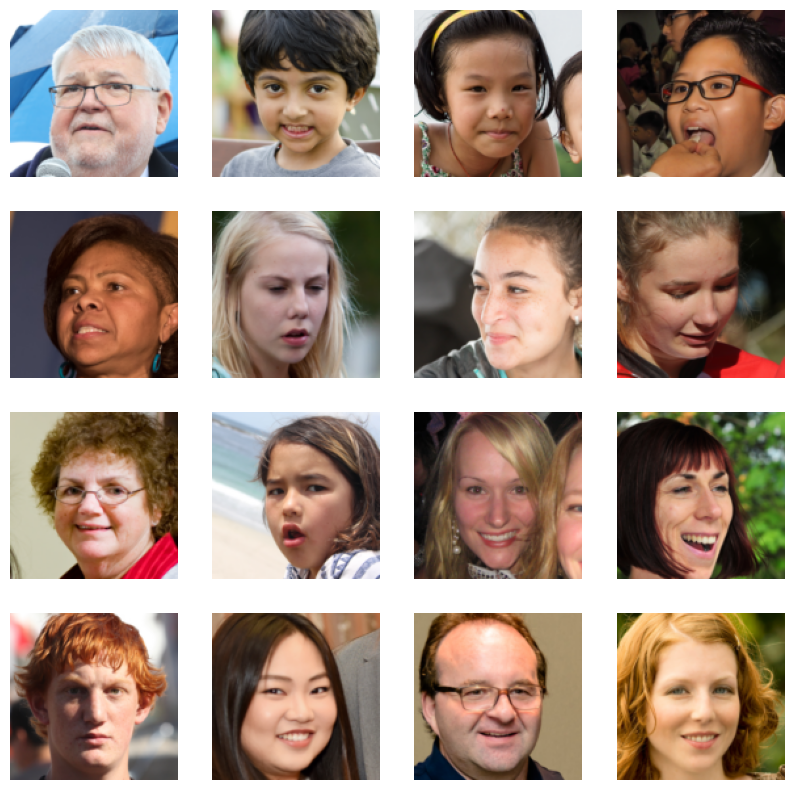

In [7]:
imgs = next(iter(image_loader))

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[0][i].permute(1, 2, 0))
    ax.axis('off')

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [8]:
def conv_block(incannel, outchannel, kernel_size=3, stride=2, padding=1):
    return nn.Conv2d(incannel, outchannel, kernel_size=kernel_size, stride=stride, padding=padding), nn.BatchNorm2d(outchannel), nn.LeakyReLU(0.2, inplace=True)
def conv_transpose_block(incannel, outchannel, kernel_size=4, stride=2, padding=1, output_padding=1):
    return nn.ConvTranspose2d(incannel, outchannel, kernel_size=kernel_size, stride=stride, padding=padding), nn.BatchNorm2d(outchannel), nn.ReLU(True) # , output_padding=output_padding

In [9]:
discriminator = nn.Sequential(*conv_block(3, 64),
                               *conv_block(64, 128),
                               *conv_block(128, 256, kernel_size=4, stride=4),
                               *conv_block(256, 512, kernel_size=4, stride=4),
                               nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=1),
                               nn.Flatten(),
                               nn.Sigmoid())

In [10]:
LATENT_SIZE = 64

generator = nn.Sequential(*conv_transpose_block(LATENT_SIZE, 512, stride=1, padding=0),
                          *conv_transpose_block(512, 256),
                          *conv_transpose_block(256, 128),
                          *conv_transpose_block(128, 64),
                          *conv_transpose_block(64, 32),
                          *conv_transpose_block(32, 16),
                          nn.Conv2d(16, 3, kernel_size=1, stride=1, padding=0),
                          nn.Sigmoid())

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

torch.Size([32, 3, 128, 128])


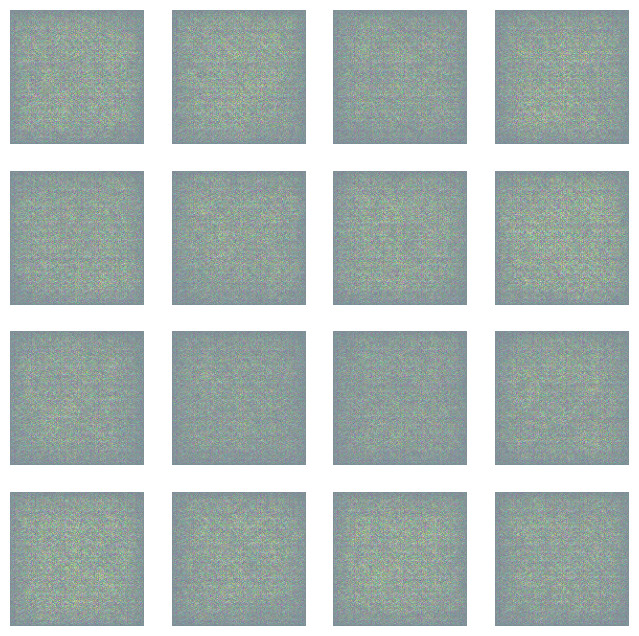

In [11]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1)

with torch.no_grad():
    fake_images = generator(xb)
print(fake_images.shape)

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(8, 8))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_images[i].permute(1, 2, 0).detach().to('cpu').numpy())
    ax.axis('off')

In [12]:
from IPython import display

def fit(model, criterion, epochs, lr):
    discriminator = model['discriminator'].train()
    generator = model['generator'].train()
    torch.cuda.empty_cache()

    dis_optimizer = torch.optim.Adam(discriminator.parameters(),
                                            lr=lr, betas=(0.5, 0.999))
    gen_optimizer = torch.optim.Adam(generator.parameters(),
                                        lr=lr, betas=(0.5, 0.999))

    dis_loss_fn = criterion['discriminator']
    gen_loss_fn = criterion['generator']

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    for epoch in range(epochs):
        print(f'EPOCH: {epoch+1}/{epochs}')

        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images, _ in tqdm(image_loader):
            real_images = real_images.to(DEVICE)

            #  train discriminator
            dis_optimizer.zero_grad()

            pred_for_real = discriminator(real_images)
            pred_for_fake = discriminator(
                generator(
                    torch.randn(real_images.size(0), LATENT_SIZE, 1, 1, device=DEVICE)
                )
            )

            target_for_real = torch.ones(real_images.size(0), 1, device=DEVICE)
            target_for_fake = torch.zeros(real_images.size(0), 1, device=DEVICE)

            loss_real = dis_loss_fn(pred_for_real, target_for_real)
            loss_fake = dis_loss_fn(pred_for_fake, target_for_fake)

            cur_real_score = torch.mean(pred_for_real).item()
            cur_fake_score = torch.mean(pred_for_fake).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            loss_d = loss_real + loss_fake
            loss_d.backward()
            dis_optimizer.step()
            loss_d_per_epoch.append(loss_d.item())

            #  train generator
            gen_optimizer.zero_grad()
            fake_images = generator(
                torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=DEVICE)
            )

            pred = discriminator(fake_images)
            target = torch.ones(BATCH_SIZE, 1, device=DEVICE)
            loss_g = gen_loss_fn(pred, target)

            loss_g.backward()
            gen_optimizer.step()
            loss_g_per_epoch.append(loss_g.item())

        #  get statistic
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        display.clear_output(wait=True)
    torch.cuda.empty_cache()

    return losses_g, losses_d, real_scores, fake_scores

In [13]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(DEVICE),
    "generator": generator.to(DEVICE)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [14]:
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, 50, lr)

EPOCH: 50/50


  0%|          | 0/99 [00:00<?, ?it/s]

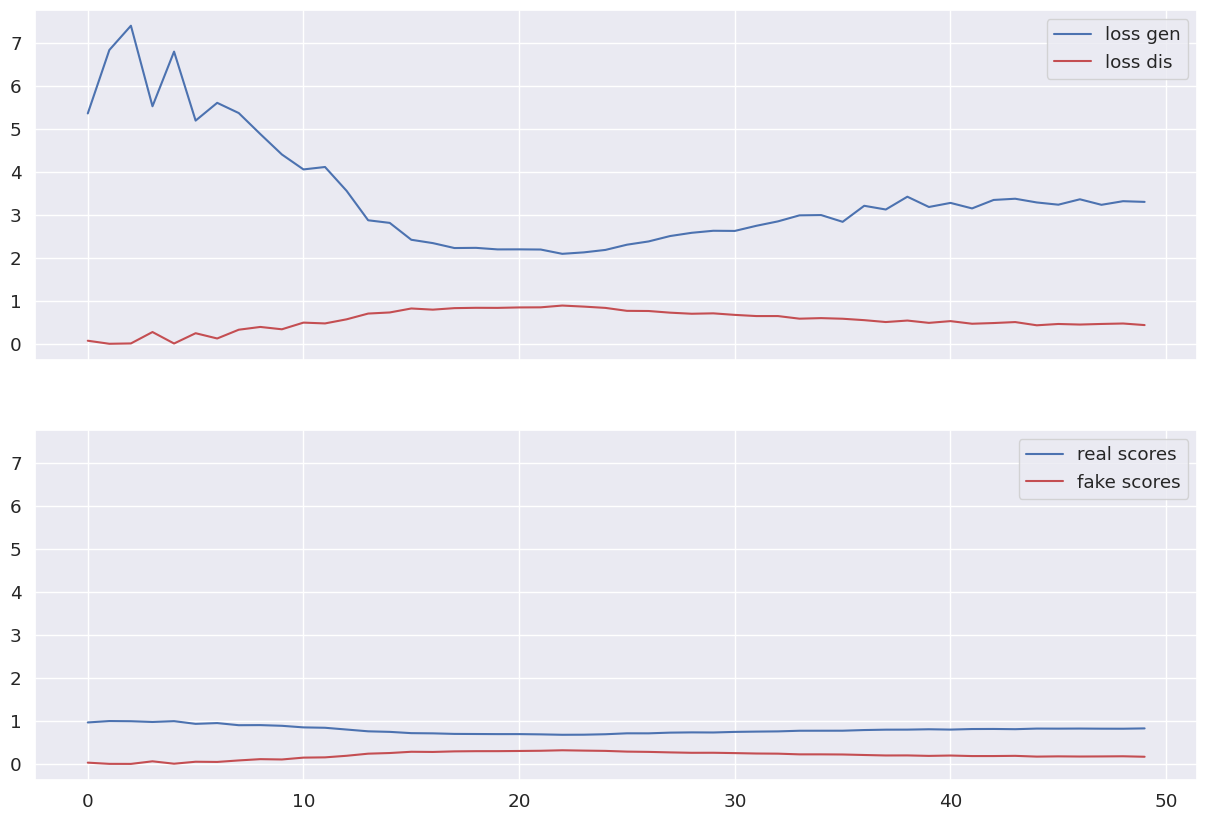

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.flatten()

x = [i for i in range(50)]

axs[0].plot(x, losses_g, color='b', label='loss gen')
axs[0].plot(x, losses_d, color='r', label='loss dis')
axs[0].legend()

axs[1].plot(x, real_scores, color='b', label='real scores')
axs[1].plot(x, fake_scores, color='r', label='fake scores')
axs[1].legend()

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [16]:
def show_images(generated):
    d = generated.shape[0]
    fig, axs = plt.subplots(nrows=int(np.ceil(d/4)), ncols=4, figsize=(15, 15))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(generated[i].detach().permute(1, 2, 0).to('cpu').numpy())
        ax.axis('off')

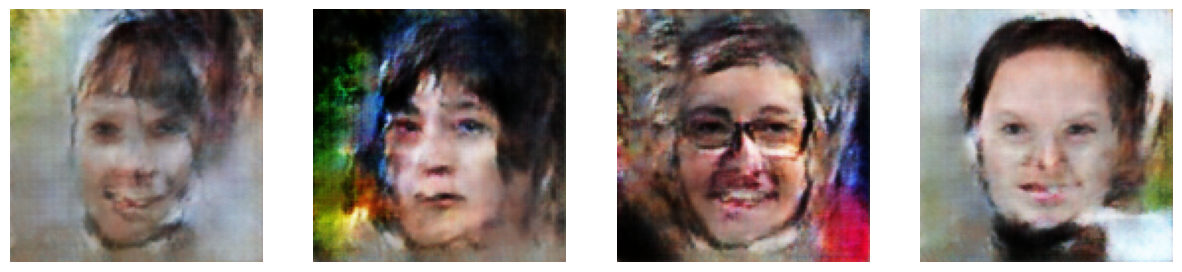

In [17]:
n_images = 4
fixed_latent = torch.randn(n_images, LATENT_SIZE, 1, 1, device=DEVICE)

with torch.no_grad():
    model["generator"].eval()
    fake_images = model["generator"](fixed_latent)

show_images(fake_images)

Как вам качество получившихся изображений?

Изображения получились очень не четкими, как будто их красками рисовал начинающий художник. При большем количестве эпох (> 50) можно будет добится большей детализации и четкости. При этом на данном этапе, сгененрированные изображения хорошо напоминают лица людей, у некоторых есть даже что-то похожее на аксесуары в виде очков.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [18]:
X = []
Y = []
step = 4

model['generator'].eval()
for X_batch, _ in image_loader:
    real_label = np.ones([X_batch.size(0), 1])
    fake_label = np.zeros([X_batch.size(0), 1])

    X.extend(X_batch.numpy()[::step])
    Y.extend(real_label[::step])

    latent = torch.randn(X_batch.size(0), LATENT_SIZE, 1, 1, device=DEVICE)
    with torch.no_grad():
        fake = model['generator'](latent).to('cpu').numpy()
    X.extend(fake[::step])
    Y.extend(fake_label[::step])

len(X), len(Y)

(1572, 1572)

In [36]:
X_ = np.array(X)
n, x, y, z = X_.shape
X_ = X_.reshape((n, x*y*z))

Y_ = Y

In [37]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

cv = LeaveOneOut()

#build multiple linear regression model
model = KNeighborsClassifier(n_neighbors=1)

#use LOOCV to evaluate model
scores = cross_val_score(model, X_, Y_, scoring='accuracy',
                         cv=cv, n_jobs=-1)

In [38]:
scores.mean()

0.8676844783715013

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Судя по полученной точности, можно сказать, что сгенерированные изображения похожи на настоящие. При увелечении accuracy качество генерации так же улучшилось бы.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [39]:
fake = []
real = []

for i, im in enumerate(X):
    if Y[i] == 1:
        real.append(im)
    else:
        fake.append(im)

len(fake), len(real)

(786, 786)

In [40]:
fake_ = np.array(fake)
n, x, y, z = fake_.shape
fake_ = fake_.reshape((n, x*y*z))
real_ = np.array(real).reshape((n, x*y*z))

In [41]:
from sklearn.manifold import TSNE

Прокомментируйте получившийся результат:

In [42]:
real_tnse = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(real_)

fake_tnse = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(fake_)

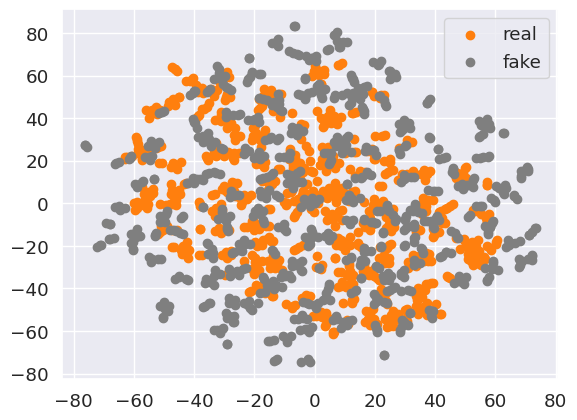

In [48]:
xr, yr = real_tnse[::, 0], real_tnse[::, 1]
plt.scatter(xr, yr, c='#ff7f0e', label='real')

xf, yf = fake_tnse[::,0], fake_tnse[::,1]
plt.scatter(xf, yf, c='#7f7f7f', label='fake')

plt.legend()
plt.show()

На графике мы видим, что распределение фейковых изображений похоже на распределение настоящих изображений, но при этом, видно, что фейковые изображение имеют большую дисперсию. Этим можно объяснить смазаность сгенерированных изображений.